<a href="https://colab.research.google.com/github/ismail51998/BIG_DATA_CLOUD_SENTIMENT_ANALYSIS/blob/main/projet_pfS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-12-25 14:51:46--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-12-25 14:51:47--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-12-25 14:51:47--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:44

In [3]:
import seaborn as sns
import pandas as pd

In [4]:
pip install pyspark

In [1]:
import sparknlp
spark = sparknlp.start()

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))



Spark NLP version: 3.3.4
Apache Spark version: 3.0.3


In [2]:
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

In [7]:
from pyspark.sql import SparkSession

sprk = SparkSession.builder\
        .appName("App")\
        .getOrCreate()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

In [21]:
data = spark.read.csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv',inferSchema=True,header=False)

In [6]:
df=pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', 
                 encoding = DATASET_ENCODING, names=DATASET_COLUMNS)

In [7]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df = df.astype({"target": str})

In [9]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
df["target"].replace({"0": "negative", "4": "positive"}, inplace=True)

In [10]:
data=spark.createDataFrame(df)

In [12]:
data_pd=data.toPandas()

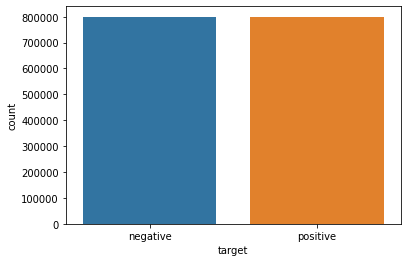

In [12]:
sns.countplot(data=data_pd,x='target')


In [12]:
dividedData = data.randomSplit([0.1, 0.9]) 
data = dividedData[0] #index 0 = data training
train_rows = data.count()
print ("Training data rows:", train_rows)

Training data rows: 15910


In [14]:
div=data.randomSplit([0.8,0.2])
df_train=div[0]
df_test=div[1]
train_rows = df_train.count()
test_rows = df_test.count()
print ("Training data rows:", train_rows,"test rows :",test_rows)

Training data rows: 12693 test rows : 3217


In [15]:
df_train=df_train.select("text","target")

In [16]:
df_train.show()

+--------------------+--------+
|                text|  target|
+--------------------+--------+
|Kind of longs for...|negative|
|@DonnieWahlberg I...|negative|
|I wanna sneak int...|negative|
|Dammit... I need ...|negative|
|@nick_carter Come...|negative|
|@danielledeleasa ...|negative|
|White trash vs us...|negative|
|i thought you wou...|negative|
|@M4RKM  You stuck...|negative|
|@charleneli Disqu...|negative|
|i wanna write, bu...|negative|
|watching the road...|negative|
|oh wtf @ house. N...|negative|
|@PhillyD Awe it a...|negative|
|@iwouldificould H...|negative|
|Observe &amp; Rep...|negative|
|@therealswizzz i ...|negative|
|Completely addict...|negative|
|fucken a man lol....|negative|
|@RyanSeacrest Tie...|negative|
+--------------------+--------+
only showing top 20 rows



In [17]:
df_train.groupby("target").count().show()

+--------+-----+
|  target|count|
+--------+-----+
|positive| 6393|
|negative| 6300|
+--------+-----+



In [18]:
document = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

token = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normal")

vivekn = ViveknSentimentApproach() \
    .setInputCols(["document", "normal"]) \
    .setSentimentCol("target") \
    .setOutputCol("result_sentiment")

finisher = Finisher() \
    .setInputCols(["result_sentiment"]) \
    .setOutputCols("final_sentiment")


In [19]:
pipeline = Pipeline().setStages([document, token, normalizer, vivekn, finisher])


In [20]:
pipelineModel = pipeline.fit(df_train)

In [22]:
df_t=df_test.select("text")

In [24]:
df_t.show()

+--------------------+
|                text|
+--------------------+
|          @mandayyy |
|@misstoriblack co...|
|Gah, Comcast doub...|
|@LarrissaR please...|
|8:00am typical Br...|
|Downloading the t...|
|wanting some suns...|
|@Charliecondou 4S...|
|WANTS TO BUY BIG ...|
|isn't feeling wel...|
|I wish there was ...|
|Dindle Manksniff ...|
|@allaboutenergy D...|
|@charlotteSK feel...|
|@JoanneSkywalker ...|
|bored as hell but...|
|I can already tee...|
|  is still at work. |
|i am tired...i do...|
|Major headache co...|
+--------------------+
only showing top 20 rows



In [25]:
result = pipelineModel.transform(df_t)

In [26]:
result.select("final_sentiment").show(truncate=False)

+---------------+
|final_sentiment|
+---------------+
|[na]           |
|[negative]     |
|[positive]     |
|[negative]     |
|[negative]     |
|[negative]     |
|[positive]     |
|[negative]     |
|[negative]     |
|[negative]     |
|[negative]     |
|[positive]     |
|[positive]     |
|[negative]     |
|[positive]     |
|[negative]     |
|[negative]     |
|[negative]     |
|[negative]     |
|[negative]     |
+---------------+
only showing top 20 rows



In [29]:
def GetValueFromDataframe(_df,columnName):
  s=[]
  for row in _df.rdd.collect():       
    s.append(row[columnName].strip())
  return s



In [46]:
def GetRes(_df,columnName):
  s=[]
  for row in _df.rdd.collect():
    if(len(row[columnName]))==0:
      s.append("")
    else:       
      s.append(row[columnName][0])
  return s


In [32]:
true = GetValueFromDataframe(df_test,"target")

In [36]:
predicted = GetRes(result,"final_sentiment")

In [39]:
valid=0
for i in range(len(predicted)):
  if predicted[i]==true[i]:
    valid+=1
accuracy=valid/len(predicted)
  

In [40]:
accuracy

0.7367112216350638

# TEST

In [41]:
document = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

token = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")\
    .setLowercase(True)\
    .setCleanupPatterns(["(@[A-Za-z0-9]+)","http\S+","[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)
lemmatizer = Lemmatizer() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma") \
    .setDictionary("/content/drive/MyDrive/lemmas_small.txt.txt", "->", "\t")


vivekn = ViveknSentimentApproach() \
    .setInputCols(["document", "lemma"]) \
    .setSentimentCol("target") \
    .setOutputCol("result_sentiment")

finisher = Finisher() \
    .setInputCols(["result_sentiment"]) \
    .setOutputCols("final_sentiment")


In [42]:
pipeline = Pipeline().setStages([document, token, normalizer,stopwords_cleaner,lemmatizer, vivekn, finisher])


In [43]:
pipelineModel = pipeline.fit(df_train)

In [47]:
result = pipelineModel.transform(df_t)
true = GetValueFromDataframe(df_test,"target")
predicted = GetRes(result,"final_sentiment")


In [48]:
valid=0
for i in range(len(predicted)):
  if predicted[i]==true[i]:
    valid+=1
accuracy=valid/len(predicted)
accuracy

0.729250854833696

# PARTIE NON ENCORE FAITE

In [ ]:
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")
regexTokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")\
    .setLowercase(True)\
    .setCleanupPatterns(["(@[A-Za-z0-9]+)","http\S+","[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)
lemmatizer = Lemmatizer() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma") \
    .setDictionary("/content/drive/MyDrive/lemmas_small.txt.txt", "->", "\t")
#finisher = Finisher() \
#   .setInputCols(["lemma"]) \
#    .setCleanAnnotations(False)
tokenAssembler = TokenAssembler() \
    .setInputCols(["document", "lemma"]) \
    .setOutputCol("cleanText")
"""embeddings = WordEmbeddingsModel.pretrained() \
    .setInputCols(["cleanText","lemma"]) \
    .setOutputCol("embeddings")
embeddingsSentence = SentenceEmbeddings() \
    .setInputCols([ "documment","embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

embeddingsFinisher = EmbeddingsFinisher() \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCols("finished_embeddings") \
    .setOutputAsVector(True) \
    .setCleanAnnotations(False)"""
embeddings = WordEmbeddingsModel.pretrained(name='glove_100d') \
    .setInputCols(["cleanText", "lemma"]) \
    .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["cleanText", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

embeddingsFinisher = EmbeddingsFinisher() \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCols("finished_embeddings") \
    .setOutputAsVector(True) \
    .setCleanAnnotations(False)
"""
embeddingsFinisher = EmbeddingsFinisher() \
    .setInputCols(["embeddings"]) \
    .setOutputCols("finished_embeddings") \
    .setOutputAsVector(True)
"""

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


'\nembeddingsFinisher = EmbeddingsFinisher()     .setInputCols(["embeddings"])     .setOutputCols("finished_embeddings")     .setOutputAsVector(True)\n'

In [ ]:
pipeline = Pipeline() \
    .setStages([
      documentAssembler,
      regexTokenizer,
      normalizer,
      stopwords_cleaner,
      lemmatizer,
      tokenAssembler,
      embeddings,
      embeddingsSentence,
      embeddingsFinisher
    ])

In [ ]:
m=pipeline.fit(df_train)


AttributeError: ignored

In [ ]:
df_train=m.transform(df_train)

AttributeError: ignored

In [ ]:
df_train.show(
)

+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|target|            document|               token|          normalized|         cleanTokens|               lemma|           cleanText|          embeddings| sentence_embeddings| finished_embeddings|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 ...|     0|[[document, 0, 51...|[[token, 43, 51, ...|[[token, 43, 51, ...|[[token, 43, 51, ...|[[token, 43, 51, ...|[[document, 0, 8,...|                  []|[[sentence_embedd...|                [[]]|
|                 ...|     0|[[document, 0, 65...|[[token, 37, 37, ...|[[token, 37, 37, ...|[[token, 39, 42, ...|[[token, 39

In [ ]:
df_train=df_train.selectExpr("text","explode(finished_embeddings) as result","target").show(5, 80)

+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+------+
|                                                                            text|                                                                          result|target|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+------+
|                                                                       exhausted|                                                                              []|     0|
|                                                   I miss her so much already...|                                                                              []|     0|
|                                                I missed the New Moon trailer...|                                                               

In [ ]:
from pyspark.ml.classification import *


In [ ]:
pip install pyspark

In [ ]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)
assembler = VectorAssembler(inputCols=[
'result'],outputCol='features')

TypeError: ignored

In [ ]:
M=assembler.transform(df_train)

AttributeError: ignored

In [ ]:
lr = LogisticRegression(labelCol="target", featuresCol="result", 
                        maxIter=100, regParam=0.01)
model = lr.fit(df_train)
print ("Training is done!")

AttributeError: ignored